# Intro

This notebook is part of a series of notebooks that aim to reuse open-source LLM models to perform a binary classification task.

Notebooks can be run completely independently from the others and besides dataset_utils.py have no common local dependencies. (As a result,
you can expect a little bit of code redundancy between notebooks) 

**The task is to detect toxic comments out of text comments retrieved from different news websites.**

For more information, see dataset_utils.py or search for 'Civil Comments dataset' online.

-----
This notebook loads a pretrained model, adds a classifier head on it and train only that classifier head (keeping the rest frozen)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import evaluate

# AutoModelForSequenceClassification enables us to plug a prtrained model to a classifier head easily
from transformers import (
    pipeline, AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments,
)
from datasets import Value


from utils import dataset_utils

Datasets cache is False


# Load dataset

In [2]:
comments_dataset = dataset_utils.load_sampled_ds(ds_size={
    "train": 1000,  # Adding more on the train split in this notebook, although this is still a bit insufficient to avoid overfitting...
    "validation": 200,
    "test": 200,
})

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [3]:
comments_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 200
    })
})

In [4]:
comments_dataset = (comments_dataset
    .cast_column("is_toxic", Value(dtype='int8'))
    .rename_column("is_toxic", "label") # for trainer
)

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

# Load model

In [5]:
#model_name = "google-t5/t5-base" # for faster training loop
model_name = "google-t5/t5-large" # Fully fine tuning this model will likely crash a T4, but training a classifier head on it should work
# model_name = "google-t5/t5-11b"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2 # Binary classification
)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# You might get a warning like:
"""
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
"""
# -> It shows, as expected, that the classifier head is not trained... which we are going to do now.

"\nSome weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']\nYou should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.\n"

In [7]:
# Setup dataset batches
comments_dataset = comments_dataset.map(
    lambda example: tokenizer(example["text"], padding=True, truncation=True), batched=True
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [8]:
model

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=1024, out_features=4096, bias=False)
                (wo): Lin

In [9]:
# We are freezing all models parameters to only train the classifier head
for param in model.transformer.parameters():
    param.requires_grad = False

In [11]:
# what we'll train
model.classification_head

T5ClassificationHead(
  (dense): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (out_proj): Linear(in_features=1024, out_features=2, bias=True)
)

In [12]:
# The dataset is imbalanced, the custom trainer simply adds weights in the loss function
# to account for the imbalance.
# [Exercise] Try with and without the CustomTrainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss to correct for imbalance
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 10.0]).to(self.model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [15]:
training_args = TrainingArguments(
    "classifier-head-trainer",
    report_to="none",
    num_train_epochs=5.0, # Might benefit being run a little longer, but that would take more time!
    save_strategy="no", # Low disk space, don't save checkpoints, esp w big models
    eval_strategy="epoch",
    learning_rate=0.001,
    logging_strategy="epoch",
    per_device_train_batch_size=256, # Optimise for GPU usage, check 'nvidia-smi' when the trainer is running
)


trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=comments_dataset["train"],
    eval_dataset=comments_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/tmp/ipykernel_3964/820145358.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.850200,0.688154
2,0.758300,0.616562
3,0.651300,0.733592
4,0.599100,0.625804
5,0.562100,0.618658


TrainOutput(global_step=20, training_loss=0.6842196106910705, metrics={'train_runtime': 907.8229, 'train_samples_per_second': 5.508, 'train_steps_per_second': 0.022, 'total_flos': 6161805544500000.0, 'train_loss': 0.6842196106910705, 'epoch': 5.0})

# Global evaluation and Threshold selection


In [17]:
def softmax(predictions):
    # Subtract the max for numerical stability
    exp_preds = np.exp(predictions)
    return exp_preds / np.sum(exp_preds, axis=1)[..., np.newaxis]


In [18]:
# Would benefit using a map method instead
for split in ["train", "validation", "test"]:
    comments_dataset[split] = comments_dataset[split].add_column(
        "toxic_score",
        softmax(trainer.predict(comments_dataset[split]).predictions[0])[:, 1]
    )

In [19]:
# Eval ROC_AUC on train and valid
roc_auc_score = evaluate.load("roc_auc")
for split in ["train", "validation"]:
    auc_score = roc_auc_score.compute(
        references=comments_dataset[split]['label'],
        prediction_scores=comments_dataset[split]["toxic_score"]
    )
    print(
        f"{split} ROC_AUC: {auc_score}"
    )

train ROC_AUC: {'roc_auc': 0.8593153153153152}
validation ROC_AUC: {'roc_auc': 0.6925434116445353}


Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

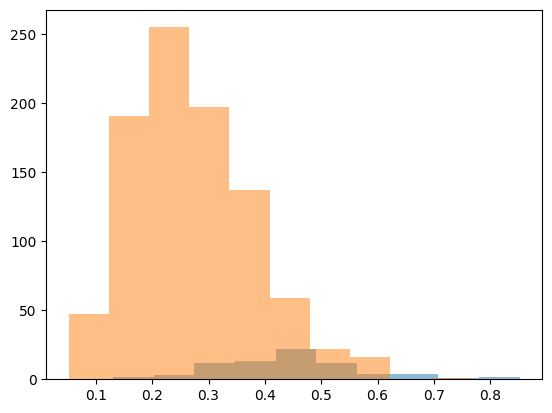

In [20]:
plt.hist(comments_dataset["train"].filter(lambda example:example["label"])["toxic_score"], alpha=0.5)
plt.hist(comments_dataset["train"].filter(lambda example:not example["label"])["toxic_score"], alpha=0.5)
plt.show()

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

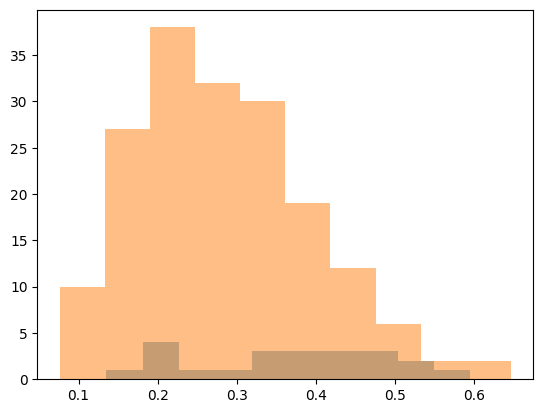

In [21]:
# Check calibrations of predictions and pick threshold manually if needed
plt.hist(comments_dataset["validation"].filter(lambda example:example["label"])["toxic_score"], alpha=0.5)
plt.hist(comments_dataset["validation"].filter(lambda example:not example["label"])["toxic_score"], alpha=0.5)
plt.show()

In [ ]:
# [Exercise] Are we overfitting? if Yes, what would you suggest?

# Evaluation

In [22]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [36]:
PROB_THRESHOLD = 0.40

In [37]:
# To check for overfitting
clf_metrics.compute(
    references=comments_dataset["train"]["label"],
    predictions=[score > PROB_THRESHOLD for score in comments_dataset["train"]["toxic_score"]]
)

{'accuracy': 0.864,
 'f1': 0.4137931034482758,
 'precision': 0.3057324840764331,
 'recall': 0.64}

In [38]:
clf_metrics.compute(
    references=comments_dataset["validation"]["label"],
    predictions=[score > PROB_THRESHOLD for score in comments_dataset["validation"]["toxic_score"]]
)

{'accuracy': 0.8, 'f1': 0.3548387096774194, 'precision': 0.275, 'recall': 0.5}

# Final Test

In [39]:
# When you're happy with your tuning, run the evaluation on the test set and report your results on the sheet!
clf_metrics.compute(
    references=comments_dataset["test"]["label"],
    predictions=[score > PROB_THRESHOLD for score in comments_dataset["test"]["toxic_score"]]
)

{'accuracy': 0.895,
 'f1': 0.3225806451612903,
 'precision': 0.2631578947368421,
 'recall': 0.4166666666666667}